Note:  
This notebook was executed on google colab pro.

In [1]:
!pip3 install pytorch-lightning --quiet

     |████████████████████████████████| 813 kB 15.0 MB/s 
     |████████████████████████████████| 10.6 MB 25.1 MB/s 
     |████████████████████████████████| 118 kB 63.7 MB/s 
     |████████████████████████████████| 829 kB 57.0 MB/s 
     |████████████████████████████████| 636 kB 55.6 MB/s 
     |████████████████████████████████| 234 kB 57.4 MB/s 
     |████████████████████████████████| 1.3 MB 79.4 MB/s 
     |████████████████████████████████| 142 kB 68.1 MB/s 
     |████████████████████████████████| 294 kB 69.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires tensorboard~=2.5, but you have tensorboard 2.4.1 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/atmacup11/experiments')

# Settings

In [4]:
EXP_NO = 23
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'
REGRESSION = True

In [5]:
assert((TARGET, REGRESSION) in (('target', True), ('target', False), ('sorting_date', True)))

In [6]:
MODEL_NAME = 'inception'
BATCH_SIZE = 128
NUM_EPOCHS = 200

# Library

In [7]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score
# from sklearnex import patch_sklearn
from pytorch_lightning import seed_everything
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from torchvision import transforms

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)

from cross_validation import load_cv_object_ids
from dataset import load_csvfiles, load_photofile,load_photofiles, AtmaImageDatasetV02
from folder import experiment_dir_of
from models import initialize_model
from utils import train_model, predict_by_model

In [8]:
pd.options.display.float_format = '{:.5f}'.format

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

# Prepare directory

In [10]:
output_dir = experiment_dir_of(EXP_NO)

In [11]:
output_dir

'../scripts/../experiments/exp023'

# Prepare logger

In [12]:
logger = getLogger(__name__)

In [13]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [14]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))
logger.info('REGRESSION: {}'.format(REGRESSION))

2021-07-21 06:48:47,747 - __main__ - INFO - Experiment no: 23
2021-07-21 06:48:47,750 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-21 06:48:47,752 - __main__ - INFO - SEED: 1
2021-07-21 06:48:47,753 - __main__ - INFO - REGRESSION: True


# Load csv files

In [15]:
SINCE = time.time()

In [16]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-21 06:48:47,769 - __main__ - DEBUG - Start loading csv files (0.008 seconds passed)
2021-07-21 06:48:49,744 - __main__ - DEBUG - Complete loading csv files (1.982 seconds passed)


In [17]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [18]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Cross validation

In [19]:
seed_everything(SEED)

Global seed set to 1


1

In [20]:
train.set_index('object_id', inplace=True)

2021-07-21 06:48:50,424 - __main__ - DEBUG - Start fold 1 (2.663 seconds passed)
2021-07-21 06:48:50,430 - __main__ - DEBUG - Start training model (2.669 seconds passed)
/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
2021-07-21 06:52:50,189 - __main__ - DEBUG - Epoch 0/199
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, st

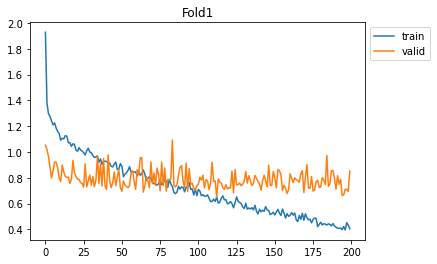

2021-07-21 08:01:03,824 - __main__ - DEBUG - Complete prediction for train fold (4336.062 seconds passed)
2021-07-21 08:01:06,731 - __main__ - DEBUG - Complete prediction for val fold (4338.969 seconds passed)
2021-07-21 08:10:10,557 - __main__ - DEBUG - Complete prediction for test fold (4882.795 seconds passed)
2021-07-21 08:10:10,578 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp023/cv_fold1_training.csv (4882.816 seconds passed)
2021-07-21 08:10:10,588 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp023/cv_fold1_validation.csv (4882.827 seconds passed)
2021-07-21 08:10:10,613 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp023/cv_fold1_test.csv (4882.851 seconds passed)
2021-07-21 08:10:10,986 - __main__ - DEBUG - Save model ../scripts/../experiments/exp023/cv_fold1_model.torch (4883.224 seconds passed)
2021-07-21 08:10:11,091 - __main__ - DEBUG - Complete fold 1 (4883.330 seconds passed)
2021-07-21 08:10:11,095

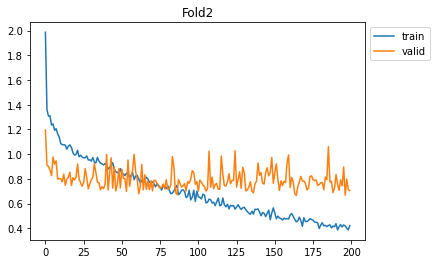

2021-07-21 09:15:30,602 - __main__ - DEBUG - Complete prediction for train fold (8802.840 seconds passed)
2021-07-21 09:15:33,455 - __main__ - DEBUG - Complete prediction for val fold (8805.693 seconds passed)
2021-07-21 09:15:49,263 - __main__ - DEBUG - Complete prediction for test fold (8821.501 seconds passed)
2021-07-21 09:15:49,283 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp023/cv_fold2_training.csv (8821.521 seconds passed)
2021-07-21 09:15:49,293 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp023/cv_fold2_validation.csv (8821.531 seconds passed)
2021-07-21 09:15:49,315 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp023/cv_fold2_test.csv (8821.553 seconds passed)
2021-07-21 09:15:49,673 - __main__ - DEBUG - Save model ../scripts/../experiments/exp023/cv_fold2_model.torch (8821.911 seconds passed)
2021-07-21 09:15:49,784 - __main__ - DEBUG - Complete fold 2 (8822.022 seconds passed)
2021-07-21 09:15:49,786

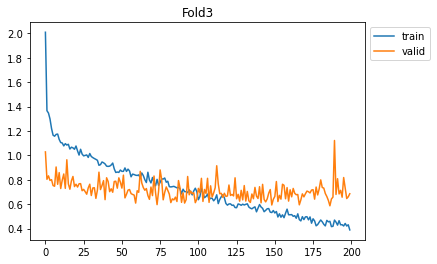

2021-07-21 10:20:49,988 - __main__ - DEBUG - Complete prediction for train fold (12722.226 seconds passed)
2021-07-21 10:20:52,685 - __main__ - DEBUG - Complete prediction for val fold (12724.923 seconds passed)
2021-07-21 10:21:07,628 - __main__ - DEBUG - Complete prediction for test fold (12739.866 seconds passed)
2021-07-21 10:21:07,646 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp023/cv_fold3_training.csv (12739.885 seconds passed)
2021-07-21 10:21:07,656 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp023/cv_fold3_validation.csv (12739.894 seconds passed)
2021-07-21 10:21:07,679 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp023/cv_fold3_test.csv (12739.918 seconds passed)
2021-07-21 10:21:08,006 - __main__ - DEBUG - Save model ../scripts/../experiments/exp023/cv_fold3_model.torch (12740.245 seconds passed)
2021-07-21 10:21:08,117 - __main__ - DEBUG - Complete fold 3 (12740.355 seconds passed)
2021-07-21 10:2

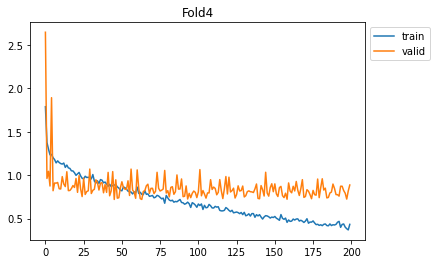

2021-07-21 11:26:10,761 - __main__ - DEBUG - Complete prediction for train fold (16642.999 seconds passed)
2021-07-21 11:26:13,706 - __main__ - DEBUG - Complete prediction for val fold (16645.945 seconds passed)
2021-07-21 11:26:29,678 - __main__ - DEBUG - Complete prediction for test fold (16661.917 seconds passed)
2021-07-21 11:26:29,697 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp023/cv_fold4_training.csv (16661.936 seconds passed)
2021-07-21 11:26:29,707 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp023/cv_fold4_validation.csv (16661.946 seconds passed)
2021-07-21 11:26:29,729 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp023/cv_fold4_test.csv (16661.967 seconds passed)
2021-07-21 11:26:30,098 - __main__ - DEBUG - Save model ../scripts/../experiments/exp023/cv_fold4_model.torch (16662.336 seconds passed)
2021-07-21 11:26:30,229 - __main__ - DEBUG - Complete fold 4 (16662.467 seconds passed)
2021-07-21 11:2

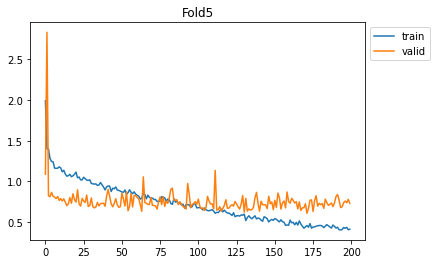

2021-07-21 12:31:44,578 - __main__ - DEBUG - Complete prediction for train fold (20576.816 seconds passed)
2021-07-21 12:31:47,456 - __main__ - DEBUG - Complete prediction for val fold (20579.695 seconds passed)
2021-07-21 12:32:02,846 - __main__ - DEBUG - Complete prediction for test fold (20595.085 seconds passed)
2021-07-21 12:32:02,865 - __main__ - DEBUG - Save training fold to ../scripts/../experiments/exp023/cv_fold5_training.csv (20595.103 seconds passed)
2021-07-21 12:32:02,875 - __main__ - DEBUG - Save validation fold to ../scripts/../experiments/exp023/cv_fold5_validation.csv (20595.113 seconds passed)
2021-07-21 12:32:02,902 - __main__ - DEBUG - Save test result ../scripts/../experiments/exp023/cv_fold5_test.csv (20595.140 seconds passed)
2021-07-21 12:32:03,251 - __main__ - DEBUG - Save model ../scripts/../experiments/exp023/cv_fold5_model.torch (20595.489 seconds passed)
2021-07-21 12:32:03,379 - __main__ - DEBUG - Complete fold 5 (20595.618 seconds passed)


In [21]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # Separate dataset into training/validation fold
    y_train = train.loc[train_object_ids, TARGET].values
    y_valid = train.loc[valid_object_ids, TARGET].values

    torch.cuda.empty_cache()
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Prepare model
    model, input_size = initialize_model(MODEL_NAME)
    model.to(DEVICE)
    ## Prepare transformers
    train_transformer = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transformer = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # Prepare dataset
    train_dataset = AtmaImageDatasetV02(train_object_ids, train_transformer, y_train)
    val_dataset = AtmaImageDatasetV02(valid_object_ids, val_transformer, y_valid)
    # Prepare dataloader
    dataloaders = {
        'train': DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()),
        'val': DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()),
    }
    ## train estimator
    estimator, train_losses, valid_losses = train_model(
        model, dataloaders, criterion=nn.MSELoss(), num_epochs=NUM_EPOCHS, device=DEVICE,
        optimizer=torch.optim.Adam(model.parameters()), log_func=logger.debug,
        is_inception=MODEL_NAME == 'inception')
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## Visualize training loss
    plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.legend(loc='upper left', bbox_to_anchor=[1., 1.])
    plt.title(f'Fold{num_fold}')
    plt.show()
    
    # Save model and prediction
    ## Prediction
    if REGRESSION:
        predictions = {}
        for fold_, object_ids_ in zip(['train', 'val', 'test'],
                                     [train_object_ids, valid_object_ids, test['object_id']]):
            # Prepare transformer
            transformer_ = transforms.Compose([
                transforms.Resize(input_size),
                transforms.CenterCrop(input_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            # Prepare dataset
            dataset_ = AtmaImageDatasetV02(object_ids_, transformer_)
            # Prepare dataloader
            dataloader_ = DataLoader(dataset=dataset_, batch_size=BATCH_SIZE, shuffle=False,
                                     num_workers=os.cpu_count())
            # Prediction
            predictions[fold_] = predict_by_model(estimator, dataloader_, DEVICE)
            logger.debug('Complete prediction for {} fold ({:.3f} seconds passed)' \
                         .format(fold_, time.time() - SINCE))
        pred_train = pd.DataFrame(data=predictions['train'], columns=['pred'])
        pred_valid = pd.DataFrame(data=predictions['val'], columns=['pred'])
        pred_test = pd.DataFrame(data=predictions['test'], columns=['pred'])
    else:  # Do not come here!
        raise NotImplemented
        try:
            pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
                                     columns=estimator.classes_)
        except AttributeError:
            pred_train = pd.DataFrame(data=estimator.decision_function(X_train),
                                      columns=estimator.classes_)
            pred_valid = pd.DataFrame(data=estimator.decision_function(X_valid),
                                      columns=estimator.classes_)
            pred_test = pd.DataFrame(data=estimator.decision_function(X_test),
                                     columns=estimator.classes_)
    ## Training set
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.torch')
    torch.save(estimator.state_dict(), filepath_fold_model)
#     with open(filepath_fold_model, 'wb') as f:
#         pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

# Evaluation

In [22]:
rmse = partial(mean_squared_error, squared=False)

In [23]:
# qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [24]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [25]:
metrics = defaultdict(list)

## Training set

In [26]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_train_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_train_df['pred'] = np.vectorize(soring_date2target)(pred_train_df['pred'])
            pred_train_df['actual'] = np.vectorize(soring_date2target)(pred_train_df['actual'])
    else:
        pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                        pred_train_df['2'], pred_train_df['3'])
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
#     score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
#     metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
# metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
# metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-21 12:32:03,438 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-21 12:32:03,468 - __main__ - DEBUG - Loss: 0.5632992281039784
2021-07-21 12:32:03,470 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-21 12:32:03,481 - __main__ - DEBUG - Loss: 0.45161671596700653
2021-07-21 12:32:03,482 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-21 12:32:03,494 - __main__ - DEBUG - Loss: 0.4289590034831099
2021-07-21 12:32:03,495 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-21 12:32:03,506 - __main__ - DEBUG - Loss: 0.7384159137878054
2021-07-21 12:32:03,506 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5
2021-07-21 12:32:03,517 - __main__ - DEBUG - Loss: 0.49080711398126026


In [27]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
if not REGRESSION:
    pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_train['actual'] = np.vectorize(soring_date2target)(pred_train['actual'])
# for c in ('pred', 'actual'):
#     pred_train[c] = pred_train[c].astype('int')
pred_train

,pred,actual
object_id,,
002bff09b09998d0be65,1.16852,1
00309fb1ef05416f9c1f,2.06738,3
003a1562e97f79ba96dc,2.14925,3
004890880e8e7431147b,0.86977,2
00718c32602425f504c1,2.11726,3
...,...,...
ffa3259fff8e6f3818a1,2.12106,3
ffd4d361756587883e48,0.84183,1
ffd794b7b311b7b7fd92,1.54000,2


In [28]:
if not (REGRESSION and TARGET == 'target'):
    print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
# score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
# metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
# logger.info('Training score: {}'.format(score))

2021-07-21 12:32:03,567 - __main__ - INFO - Training loss: 0.6382198333532018


In [29]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-21 12:32:03,593 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp023/prediction_train.csv


## Validation set

In [30]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    if REGRESSION:
        if TARGET == 'target':
            pred_valid_df['pred'].clip(lower=0, upper=3, inplace=True)
        else:
            pred_valid_df['pred'] = np.vectorize(soring_date2target)(pred_valid_df['pred'])
            pred_valid_df['actual'] = np.vectorize(soring_date2target)(pred_valid_df['actual'])
    else:
        pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                        pred_valid_df['2'], pred_valid_df['3'])        
    
    if not (REGRESSION and TARGET == 'target'):
        print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                               labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
#     score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
#     logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
#     metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
# metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
# metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-21 12:32:03,618 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1
2021-07-21 12:32:03,629 - __main__ - DEBUG - Loss: 0.8045030740923523
2021-07-21 12:32:03,630 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-21 12:32:03,640 - __main__ - DEBUG - Loss: 0.8163073868536536
2021-07-21 12:32:03,641 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-21 12:32:03,650 - __main__ - DEBUG - Loss: 0.765818365728914
2021-07-21 12:32:03,651 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4
2021-07-21 12:32:03,660 - __main__ - DEBUG - Loss: 0.8487278696930258
2021-07-21 12:32:03,661 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-21 12:32:03,671 - __main__ - DEBUG - Loss: 0.7812322430420576


In [31]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
if not REGRESSION:
    pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
if REGRESSION and TARGET == 'sorting_date':
    pred_valid['actual'] = np.vectorize(soring_date2target)(pred_valid['actual'])
# for c in ('pred', 'actual'):
#     pred_valid[c] = pred_valid[c].astype('int')
pred_valid

,pred,actual
object_id,,
002bff09b09998d0be65,0.25416,1
00309fb1ef05416f9c1f,0.58427,3
003a1562e97f79ba96dc,0.57200,3
004890880e8e7431147b,0.24040,2
00718c32602425f504c1,0.57788,3
...,...,...
ffa3259fff8e6f3818a1,0.60000,3
ffd4d361756587883e48,0.17311,1
ffd794b7b311b7b7fd92,0.42228,2


In [32]:
if not REGRESSION:
    print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
# score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
# metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
# logger.info('Validatino score: {}'.format(score))

2021-07-21 12:32:03,716 - __main__ - INFO - Validatino loss: 1.697410864263501


In [33]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-21 12:32:03,757 - __main__ - DEBUG - Write cv result to ../scripts/../experiments/exp023/prediction_valid.csv


In [34]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-21 12:32:03,771 - __main__ - DEBUG - Write metrics to ../scripts/../experiments/exp023/metrics.json


# Prediction

In [35]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [36]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
if REGRESSION:
    if TARGET == 'target':
        pred_test['pred'].clip(lower=0, upper=3, inplace=True)
    else:
        pred_test['pred'] = np.vectorize(soring_date2target)(pred_test['pred'])
else:
    pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,pred
object_id,
0009e50b94be36ccad39,1.43005
000bd5e82eb22f199f44,2.36856
0015f44de1854f617516,1.93797
00388a678879ba1efa27,2.15176
005e1e7c6496902d23f3,0.53165
...,...
ffbe65ad399b632dcbd0,2.04049
ffd7b2d646c0320c311a,1.04796
ffdb93ede17d4501e530,1.49807


In [37]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,1.43005
1,2.36856
2,1.93797
3,2.15176
4,0.53165
...,...
5914,2.04049
5915,1.04796
5916,1.49807
5917,1.87869


In [38]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [39]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-21 12:32:03,897 - __main__ - DEBUG - Write submission to ../scripts/../experiments/exp023/023_submission.csv


2021-07-21 12:32:04,046 - __main__ - DEBUG - Write figure to ../scripts/../experiments/exp023/prediction.png


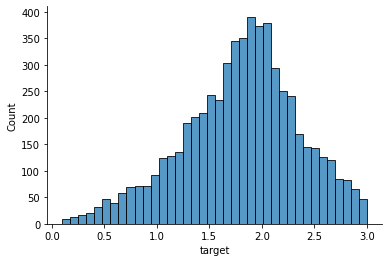

In [40]:
fig = plt.figure()
if not (REGRESSION and TARGET == 'target'):
    sns.countplot(data=test, x='target')
else:
    sns.histplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [41]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-21 12:32:04,242 - __main__ - DEBUG - Complete (20596.480 seconds passed)
